# Analyzing Flight Networks
**Author: Jalen Geason**

For the final project, I chose to analyze a directed, weighted network of commonly reoccuring flights from the website [**openflights.org**](https://openflights.org/). 

### Data Representation
The nodes represent airports while an edge (i, j) represents a recurring commercial flight between airport i and airport j. The edges are optionally weighted by distance. Nodes and edges have metadata as well.  

Node (airport) properties:  
- id
- airport name
- city
- country
- FAA code
- ICAO code
- latitude, longitude, and altitude
- timezone
- DST

Edge (flight) properties:
- distance
- airline
- airline code
- codeshare (bool)
- equipment
- stops

There are 3,214 nodes and 66,771 edges. However, for this project I only focused on nodes in the USA, meaning I only worked with 549 nodes and 2,787 edges.

### Loading and Plotting the Data

I begin by opening and reading the edgefile using `read_edgelist`. It returns a directed networkx graph.

In [1]:
import networkx as nx

fh = open(r"open-flights\edges-simple.csv", "rb")
G = nx.read_edgelist(fh, create_using=nx.DiGraph, delimiter=',', nodetype=int, edgetype=int, data=(("distance", float), ("airline_code", str), ("codeshare", bool),))
fh.close()

G

Because of the nature of commercial flights, it is very common that if a flight is available from airport i to j, there will also be one for j to i. To make sure this is true, I measured the reciprocity of the graph using `reciprocity`.

In [2]:
rec = nx.reciprocity(G)

rec

0.9780258487549788

This means that a little under 98% of the flights are round-trip, which is what we would expect for most flights. This also means that we might be able to simplify the process by making our graph undirected, which is what I do in the next step using `to_undirected`.

In [3]:
G_undir = G.to_undirected()

G_undir

I want to connect the edge data with the node data, which is in a separate file. I read the data into a `pandas` dataframe using `read_csv`.

In [4]:
import pandas as pd

data = pd.read_csv(r"open-flights\nodes.csv")

data

,# index,id,name,city,country,IATA/FAA,ICAO,latitude,longitude,altitude,timezone,DST,_pos
0,0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,"array([6.29268027, 1.37900375])"
1,1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,"array([6.30735453, 1.39906658])"
2,2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,"array([6.3014785 , 1.38535133])"
3,3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,"array([6.27849235, 1.39511825])"
4,4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,"array([6.23308524, 1.34013967])"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3209,11290,Kongolo Airport,Kongolo,Congo (Kinshasa),KOO,FZRQ,-5.394440,26.990000,1850,1.0,U,"array([5.5164688 , 1.37876336])"
3210,3210,11436,Tarko-Sale Airport,Tarko-Sale,Russia,TQL,USDS,64.930801,77.818100,82,5.0,U,"array([5.87627232, 1.43157964])"
3211,3211,11473,Jinchuan Airport,Jinchuan,China,JIC,ZLJC,38.542222,102.348333,4740,8.0,U,"array([6.169881 , 1.28830756])"
3212,3212,11498,Alashankou Bole (Bortala) airport,Bole,China,BPL,ZWAX,44.895000,82.300000,1253,8.0,N,"array([6.07268073, 1.40575676])"


Next, I want to tailor this data to only include countries in the US and to only use metadata that I need. I create a new dataframe to represent this change.

In [5]:
import numpy as np

edges = data[data[' country'] == "United States"].copy()

ap_ids = edges['# index']
node_ids = np.unique(np.array(list(ap_ids)))
nodes = pd.DataFrame(index=node_ids)

names = edges[' IATA/FAA']
countries = edges[' country']
nodes["code"] = names
nodes["country"] = countries

nodes

,code,country
1683,BTI,United States
1684,LUR,United States
1685,PIZ,United States
1686,ITO,United States
1687,BTT,United States
...,...,...
3115,OOK,United States
3136,HHH,United States
3178,OGD,United States
3179,WNA,United States


Now we need to make a new undirected graph that only includes domestic flights. For that, I simply add relevant edges in to a new `networkx` graph, remembering to also transfer edge data.

In [6]:
G_USA = nx.Graph()

for i, j in G_undir.edges():
    if i in nodes.index and j in nodes.index:
        G_USA.add_edge(i, j, **G_undir.get_edge_data(i, j))

G_USA

Next, we turn the modified graph into a numpy array using `to_numpy_array`.

In [7]:
nodelist = list(G_USA.nodes)
A = nx.to_numpy_array(G_USA, nodelist=nodelist)

A

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

With this array, we can do a lot of cool things, but first we will create a sorted heatmap using the leiden community detection algorithm (`leiden`).

C:\Users\jgeas\AppData\Roaming\Python\Python39\site-packages\beartype\_util\hint\pep\utilpeptest.py:373: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.List[numpy.ndarray] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, either drop Python < 3.9 support and globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]") or see this discussion topic for saner and more portable solutions:
    https://github.com/beartype/beartype#pep-484-deprecations
  warn(
C:\Users\jgeas\AppData\Roaming\Python\Python39\site-packages\beartype\_util\hint\pep\utilpeptest.py:373: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.List[scipy.sparse.csr.csr_matrix] deprecated by PEP 585 scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, either drop Python < 3.9 support and globally replace this hint by the equ

<AxesSubplot:>

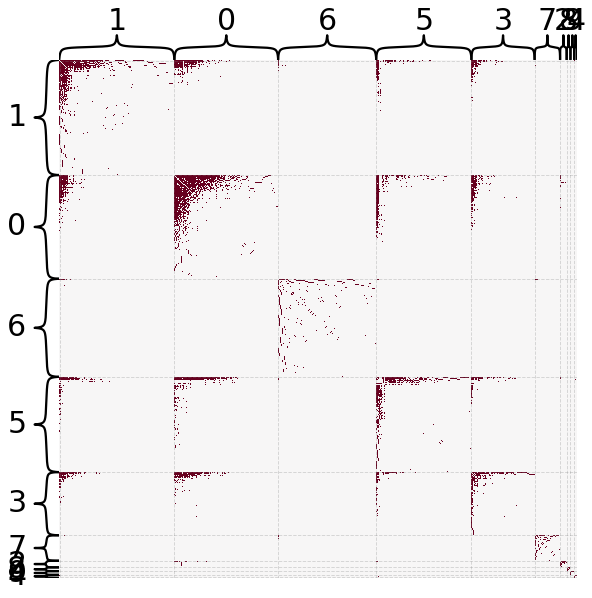

In [8]:
from graspologic.plot import heatmap
from graspologic.partition import leiden

partition_map = leiden(G_USA, trials=100)

labels = np.vectorize(partition_map.get)(nodelist)

heatmap(A, inner_hier_labels=labels, sort_nodes=True, cbar=False, transform='simple-all')

There seems to be pretty well defined communities in this network. We will now present our data in network formation using `matplotlib`. To accomplish this we will use `kamada_kawai_layout` and `draw_networkx`.

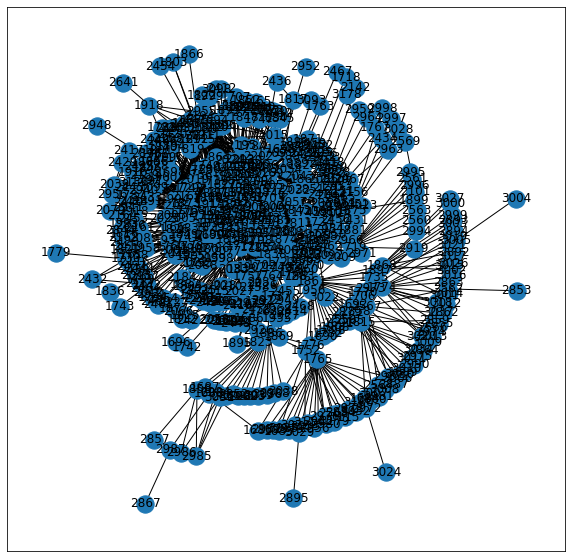

In [9]:
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(G_USA)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx(G_USA, pos=pos, ax=ax)

`graspologic` has an algorithm called `networkplot` that makes the graph look a lot more palatable by coloring the nodes based on different communities using the ledien algorithm we used earlier.

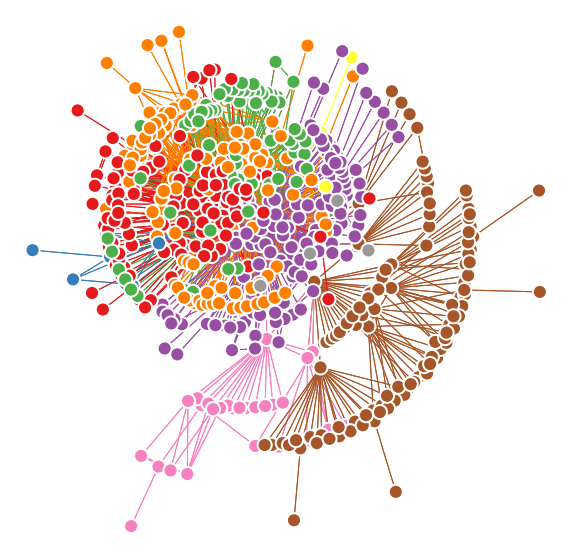

In [10]:
from graspologic.plot import networkplot

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

ax = networkplot(
    A,
    x=xs,
    y=ys,
    node_alpha=1.0,
    edge_alpha=1.0,
    edge_linewidth=1.0,
    node_hue=labels,
    node_kws=dict(s=200, linewidth=2),
)

_ = ax.axis('off')

### Analyzing the Data

Let's try to get some meaning out of this network and possibly draw some conclusions. We will turn our graph back into a numpy array them redefine our labels, making them the "colors" column of our `nodes` dataframe.

In [11]:
import seaborn as sns

nodelist = nodes.index 

A = nx.to_numpy_array(G_USA, nodelist=nodelist)
partition_map = leiden(G_USA, trials=100)

labels = np.vectorize(partition_map.get)(nodelist)

colors = sns.color_palette("husl", len(np.unique(labels)))
palette = dict(zip(sorted(np.unique(labels)), colors))
nodes["color"] = labels

nodes

,code,country,color
1683,BTI,United States,7
1684,LUR,United States,6
1685,PIZ,United States,7
1686,ITO,United States,1
1687,BTT,United States,7
...,...,...,...
3115,OOK,United States,6
3136,HHH,United States,5
3178,OGD,United States,4
3179,WNA,United States,6


We will use the `layoutplot` function borrowed from [**The Kavli-ome project**](https://docs.neurodata.io/notebooks/pedigo/graspologic/plotting/2021/03/18/kavli.html). This adds colors to label communiy detection and adds a label wich has the airport code on it.

<AxesSubplot:>

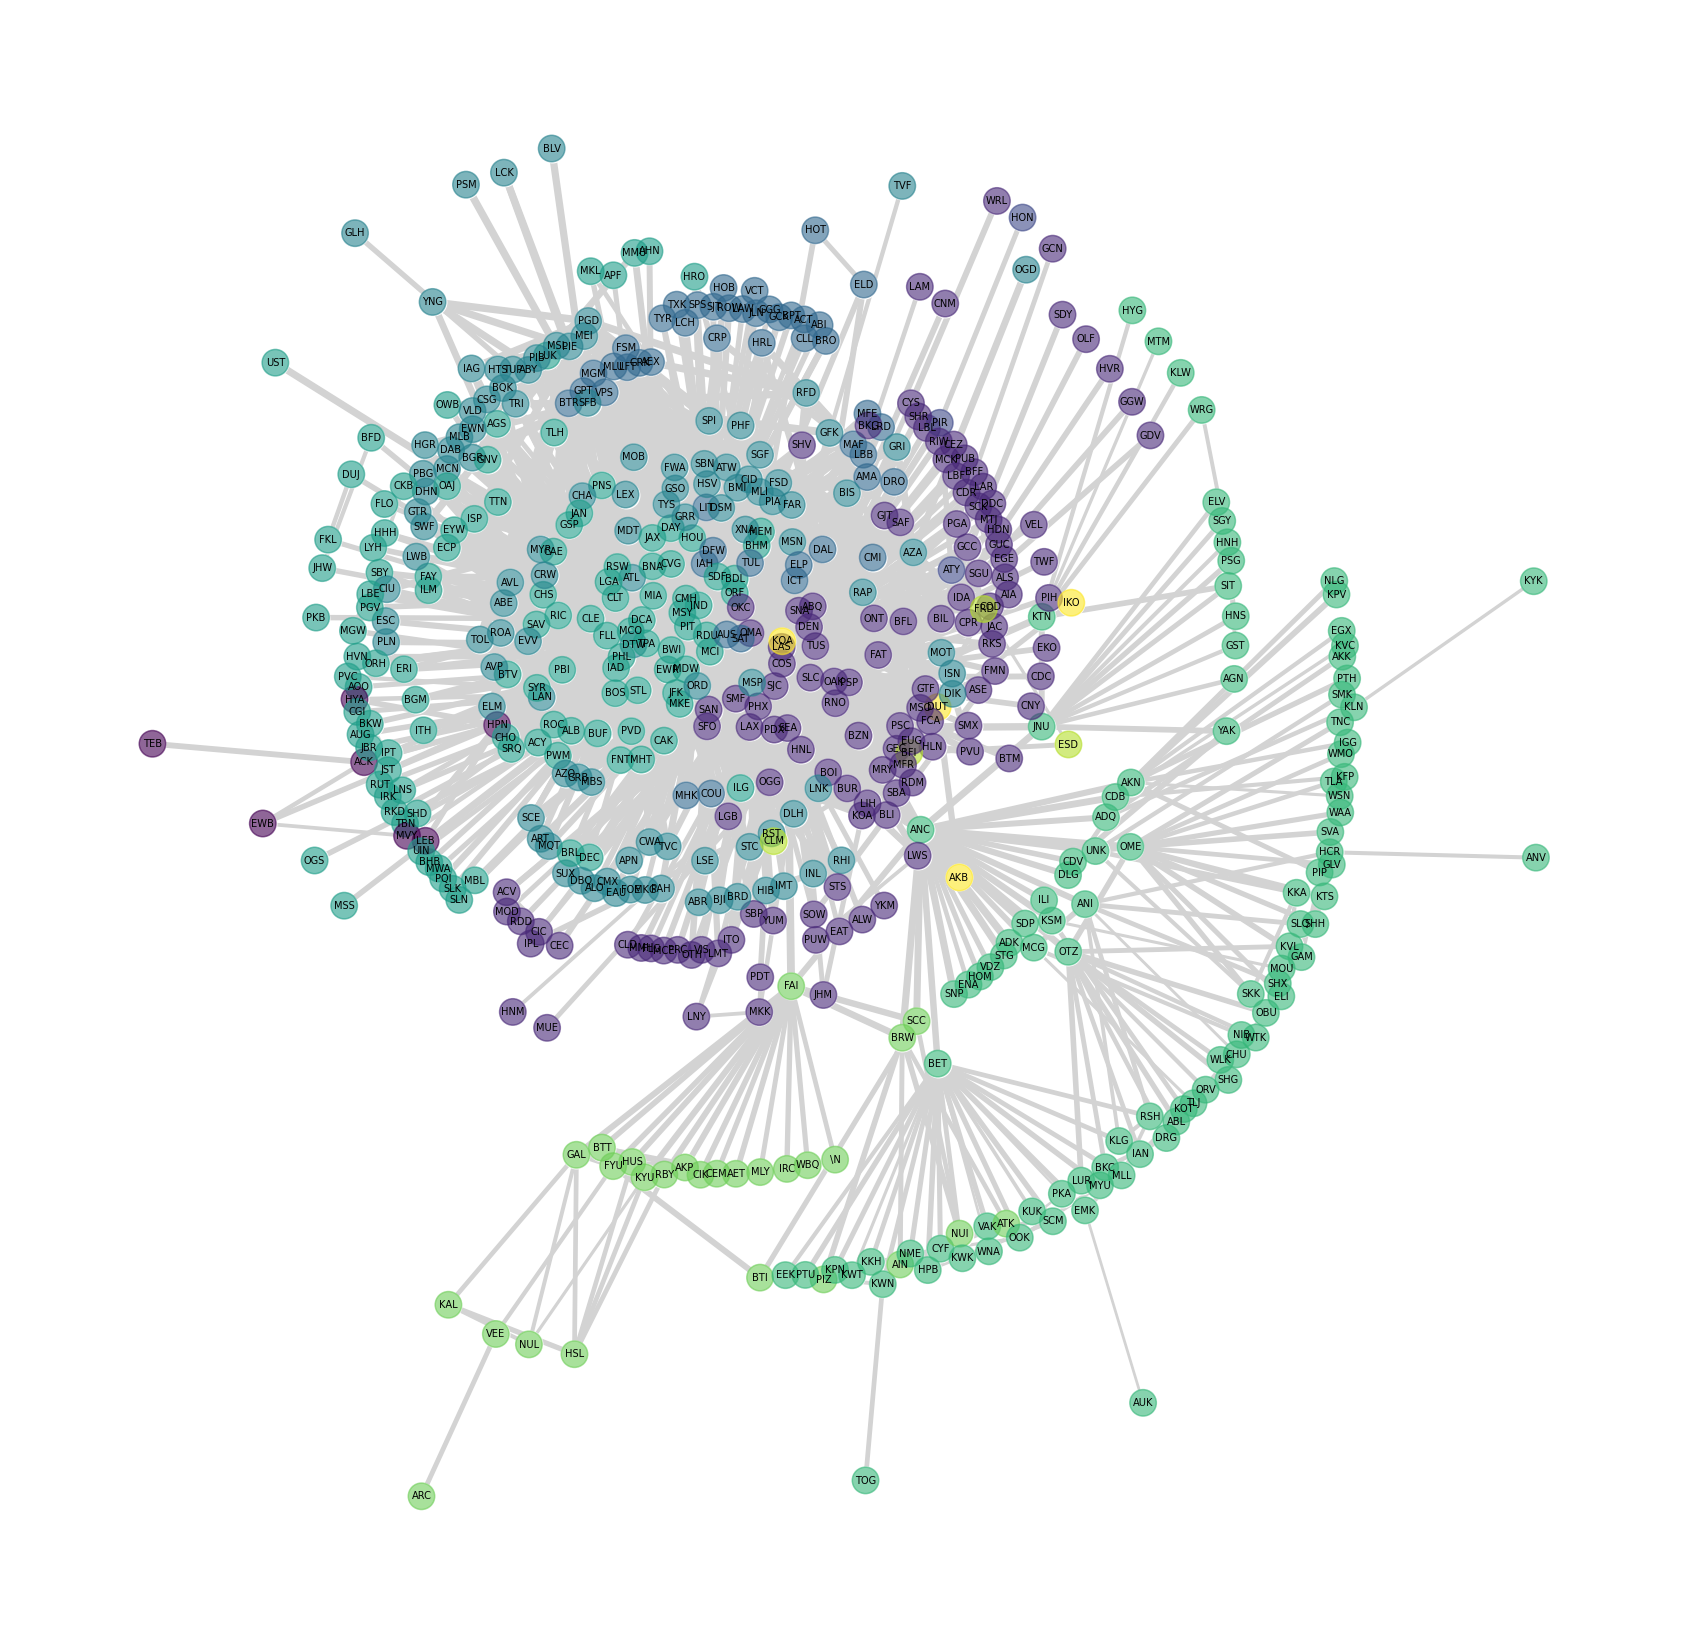

In [12]:
from adjustText import adjust_text

def layoutplot(
    g,
    pos,
    nodes,
    ax=None,
    figsize=(10, 10),
    weight_scale=1,
    adjust=True,
    log_weights=True,
    node_alpha=1,
    color=True,
    label_nodes=True,
    node_size=700,
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    edgelist = g.edges()
    weights = np.array([g[u][v]["distance"] for u, v in edgelist])
    # weight transformations happen here, can be important
    if log_weights:
        weights = np.log(weights + 1)
    weights *= weight_scale

    # plot the actual layout
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=nodes.index,
        node_color="white",
        node_size=node_size,
        ax=ax,
    )
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=nodes.index,
        node_color=nodes["color"],
        alpha=node_alpha,
        node_size=node_size,
        ax=ax,
    )
    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=edgelist,
        nodelist=nodelist,
        width=weights,
        edge_color="lightgrey",
        alpha=1,
        ax=ax,
        node_size=node_size,  # connectionstyle="arc3,rad=0.2"
    )
    if label_nodes:
        texts = []
        for node in nodes.index:
            node_pos = pos[node]
            code = nodes["code"][node]
            text = ax.text(
                node_pos[0],
                node_pos[1],
                code,
                ha="center",
                va="center",
                fontname="DejaVu Sans",
            )
            # text.set_bbox(dict(facecolor="white", alpha=0.3, edgecolor="white"))
            texts.append(text)
        if adjust:
            adjust_text(
                texts,
                expand_text=(1.03, 1.1),
                lim=200,
                avoid_self=False,
                autoalign=False,
            )

    ax.axis("off")

    return ax

layoutplot_kws = dict(node_alpha=0.6, adjust=False)

sns.set_context("talk", font_scale=0.55)
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
layoutplot(G_USA, pos, nodes, ax=ax, **layoutplot_kws)

It become apparent that the outer radius of green nodes on the bottom right is all Alaskan airports (which has [**the most airports of any US state**](https://www.statista.com/statistics/185902/us-civil-and-joint-use-airports-2008/)). The indigo nodes represent other western states. Violet colored nodes represent airports in the south central states (Missouri, Texas, etc.) while turquoise nodes representnorth central states (Ohio, Wisconsin, Michigan). Finally, the darker blue tends to represent nodes on the east coast (Florida, Maryland, Pennsylvania).  

I found it interesting that the community detection algorithm did not sort by region, but more like timezones. See map below: 

| ![timezone map](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/US-Timezones-post-2007.png/640px-US-Timezones-post-2007.png) | 
|:--:| 
| *Timezone map from [**Wikipedia**](https://en.wikipedia.org/wiki/Time_in_the_United_States)* |

Our final analysis will be using centrality measures to find the most popular airports, or hub nodes. First, we will use `degrees` to find the top 10 nodes with the highest degrees. 

In [13]:
degrees = dict(sorted(dict(G_USA.degree).items(), key=lambda item: item[1], reverse=True)).items()

list(degrees)[:10]

[(1809, 153),
 (1885, 149),
 (1853, 149),
 (1800, 138),
 (1901, 117),
 (1789, 114),
 (1914, 113),
 (1913, 110),
 (1744, 101),
 (1854, 88)]

The top 10 highest degrees are:  
1. 1809: Hartsfield-Jackson **Atlanta** International Airport  
2. 1885: **Chicago** O'Hare International Airport  
3. 1853: **Denver** International Airport  
4. 1800: **Dallas Fort Worth** International Airport  
5. 1901: **Minneapolis-St Paul** International/Wold-Chamberlain Airport  
6. 1789: **Detroit** Metropolitan Wayne County Airport  
7. 1914: McCarran International Airport (**Las Vegas**)  
8. 1913: **Charlotte** Douglas International Airport  
9. 1744: **Memphis** International Airport  
10. 1854: **Philadelphia** International Airport  

Next, we will compare these results to those from pagerank:

In [14]:
pagerank = dict(sorted(nx.pagerank(G_USA, max_iter=500).items(), key=lambda item: item[1], reverse=True)).items()

list(pagerank)[:10]

[(1853, 0.024005245228411427),
 (1809, 0.021559006114284258),
 (1885, 0.020935724525798744),
 (1800, 0.020254323025647582),
 (1901, 0.01661384446226182),
 (1914, 0.014664917040076615),
 (1789, 0.014563023840242906),
 (1913, 0.014343134529458132),
 (1744, 0.013103508699245196),
 (1861, 0.012931186356231705)]

The top 10 highest pageranks are:
1. 1853: **Denver** International Airport  
2. 1809: Hartsfield-Jackson **Atlanta** International Airport  
3. 1885: **Chicago** O'Hare International Airport  
4. 1800: **Dallas Fort Worth** International Airport  
5. 1901: **Minneapolis-St Paul** International/Wold-Chamberlain Airport  
6. 1914: McCarran International Airport (**Las Vegas**)  
7. 1789: **Detroit** Metropolitan Wayne County Airport  
8. 1913: **Charlotte** Douglas International Airport  
9. 1744: **Memphis** International Airport  
10. 1861: Ted Stevens **Anchorage** International Airport  

As we can see, the results are almost identical. Interestingly, major hub airports like JFK and LAX did not make it into the top 10 of either lists. LAX is \#12 and JFK is \#36.

```{note}
It is important to note that this data set is a sample from a finite time. Therefore, it could be possible that Atlanta just had an unusually high number of flights during this time and JFK and LAX did not.
```

### Conclusion

This data can be very useful for airlines as they consider new routes and demand for certain routes. They can also be important for passengers wanting to know what the most and least busy airports are. I can definitely see a website where a passenger can choose an airport and see how busy it is measured by how many flights are going out that day.  

Obviously these results are not perfect. Community detection did create some outliers in certain communities, and the degree and pagerank calculations could be skewed by insufficient data. But the fact that with rather minor analysis we could get this much information shows how powerful network data science can be.